Discussion <br>
KLT for short motion


Sources/References <br>
https://www.geeksforgeeks.org/python-opencv-optical-flow-with-lucas-kanade-method/ <br>
https://github.com/npinto/opencv/blob/master/samples/python2/lk_track.py (example from OpenCV docs under calcOpticalFlowPyrLK https://docs.opencv.org/4.x/dc/d6b/group__video__track.html)<br> 
OpenCV docs <br> 
Lectures

In [101]:
import sys
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
from sklearn.cluster import AgglomerativeClustering

dir = "hw6data/"

def get_images(img_dir):
    original = os.getcwd()
    os.chdir(img_dir)
    img_name_list = os.listdir('./')
    img_name_list = [name for name in img_name_list if 'png' in name.lower()]
    img_name_list.sort()
    img_list = []
    colored_img_list = []
    for i in img_name_list:
        im = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
        color_im = cv2.imread(i)
        if im is None:
            print('Could not open', i)
            sys.exit(0)
        img_list.append(im)
        colored_img_list.append(color_im)

    os.chdir(original)

    return img_name_list, img_list, colored_img_list

000003_10.png


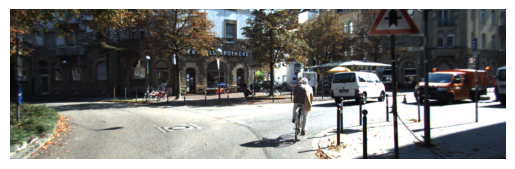

In [102]:
img_name_list, img_list, colored_img_list = get_images(dir)
print(img_name_list[0])
plt.axis('off')
plt.imshow(colored_img_list[0][:,:,::-1])
plt.show()

Num points: (1000, 1, 2)


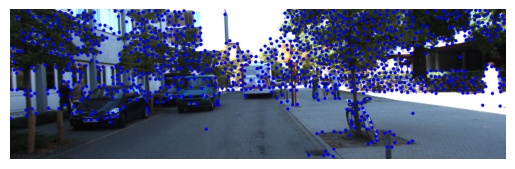

(370, 1224, 3)


In [103]:
'''Selected Points'''
img0 = img_list[0]
colored_img0 = colored_img_list[0].copy()

img1 = img_list[1]
colored_img1 = colored_img_list[1].copy()

# img0 = img_list[3]
# colored_img0 = colored_img_list[3].copy()

# img1 = img_list[4]
# colored_img1 = colored_img_list[4].copy()

img0 = img_list[len(img_list) - 12]
colored_img0 = colored_img_list[len(img_list) - 12].copy()

img1 = img_list[len(img_list) - 9]
colored_img1 = colored_img_list[len(img_list) - 9].copy()

feature_params = dict( maxCorners = 1000,
                    qualityLevel = 0.0001,  
                    minDistance = 10,   
                    blockSize = 5 )

p0 = cv2.goodFeaturesToTrack(img0,mask=None, **feature_params, useHarrisDetector=True)
p0_0 = p0.astype(np.int32)
print("Num points:",p0.shape)
for i in p0_0:
    x,y = i.ravel()
    colored_img0 = cv2.circle(colored_img0,(x,y),4,255,-1)
plt.axis('off')
plt.imshow(colored_img0[:,:,::-1])
plt.show()
print(colored_img0.shape)

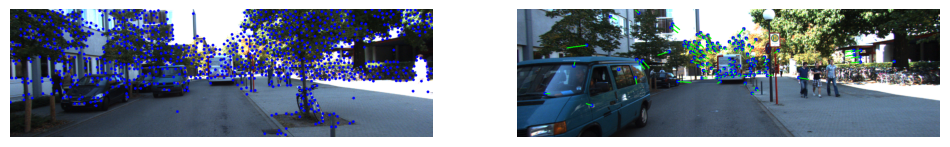

In [104]:
'''Image Motion'''

lk_params = dict( winSize  = (15, 15), 
                  maxLevel = 2, 
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)) 

p1, st, err = cv2.calcOpticalFlowPyrLK(img0, img1, p0, None, **lk_params)

#reverse optical flow to find p0 points again, ideally these points SHOULD be the same as original p0
p0r, st, err = cv2.calcOpticalFlowPyrLK(img1, img0, p1, None, **lk_params)

#we find distance between p0 and p0r and determine it is an accurate point if distance < 1 pixel
d = abs(p0-p0r).reshape(-1, 2).max(-1)
good = d < 1
good_p1 = p1[good].reshape(-1,2)
good_p0 = p0[good].reshape(-1,2)
# print(good_p1.shape)

og = colored_img0.copy()
vis = colored_img1.copy()

for (x, y), (a,b) in zip(good_p1, good_p0):
    vis = cv2.circle(vis, (int(x), int(y)), 5, 255, -1)
    vis = cv2.line(vis, (int(a), int(b)), (int(x), int(y)), (0, 255, 0), 2)

# vis = cv2.resize(vis, (4500,2500))
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(og[:,:,::-1])

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(vis[:,:,::-1])
plt.show()

In [105]:
def createLines(p0, p1):
    motion_vec = p1-p0
    lines = []
    for i in range(len(p0)):
        (u,v) = motion_vec[i]
        unit_norm = np.sqrt(np.square(u) + np.square(v))
        a = -v/unit_norm
        b = u/unit_norm
        c = -(a * p0[i][0] + b*p0[i][1])
        lines.append([a,b,c])
    return lines
        
def RANSAC(lines, samples):
    bestFOE = None
    bestCount = 0
    inliers_indices = []
    for i in range(samples):
        #finding a candidate FOE
        sample = np.random.randint(0, len(lines), 2)
        if sample[0] == sample[1]:
            continue
        A = np.array([lines[sample[0]], lines[sample[1]]])
        #SVD spits out U (left singular vec), sigma (singular val), Vh(right singular vec), we want Vh
        V = np.linalg.svd(A)[2]
        ph = V[2]
        #candidate FOE (x,y,z)
        p = ph/ph[2]
        
        lineCount = 0
        #test remaining lines on FOE
        for j in range(len(lines)):
            if j == sample[0] or j == sample[1]:
                continue
            currentLine = lines[j]
            distance = np.absolute(np.dot(currentLine, p))
            #threshold
            if distance < 3:
                lineCount += 1
                if j not in inliers_indices:
                    inliers_indices.append(j)
                
                
        if bestCount < lineCount:
            bestCount = lineCount
            bestFOE = p
            
    return bestFOE, np.array(inliers_indices)

FOE: [640.6086 194.511    1.    ]


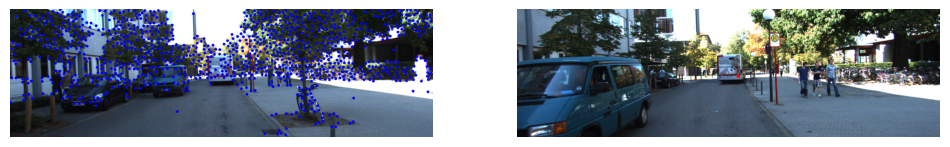

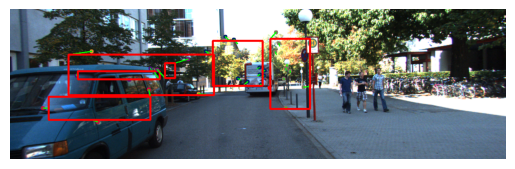

In [106]:
lines = createLines(good_p0, good_p1)
FOE, inliers = RANSAC(lines, 30)

print("FOE:",FOE)
if not FOE is None:
    x, y, z = FOE
    vis = cv2.circle(vis, (int(x), int(y)), 5, (0,0,255), -1)
    vis = cv2.circle(colored_img1, (int(x), int(y)), 5, (0,0,255), -1)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(og[:,:,::-1])

    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(vis[:,:,::-1])
    plt.show()
    
    mask = np.zeros(len(good_p0), dtype=bool)
    mask[inliers] = True
    s = good_p0[~mask]
    k = good_p1[~mask]
    motion = k-s
    X = np.concatenate((s, motion), axis=1)

    def custom_distance(point1,point2):
        u, v = point1[2], point1[3]
        u1, v1 = point2[2], point2[3]
        motion_vector_dot_product = u * u1 + v * v1
        position_difference = np.abs(np.array(point1[:2]) - np.array(point2[:2]))
        distance = motion_vector_dot_product + np.sum(position_difference)
        return distance
    
    def dist_matrix(points):
        num_points = len(points)
        distance_matrix = np.zeros((num_points, num_points))
        for i in range(num_points):
            for j in range(num_points):
                distance_matrix[i, j] = custom_distance(points[i], points[j])
        return distance_matrix
    
    mat = dist_matrix(X)
    cluster = AgglomerativeClustering(n_clusters=6, metric='precomputed',compute_full_tree=True,linkage='complete')

    labels = cluster.fit_predict(mat)
    
    def calculate_bounding_box(cluster_points):
        min_x = np.min(cluster_points[:, 0])
        max_x = np.max(cluster_points[:, 0])
        min_y = np.min(cluster_points[:, 1])
        max_y = np.max(cluster_points[:, 1])
        return min_x, max_x, min_y, max_y
    
    for cluster_label in np.unique(labels):
        cluster_p0 = s[labels == cluster_label]
        cluster_p1 = k[labels == cluster_label]
        min_x, max_x, min_y, max_y = calculate_bounding_box(cluster_p0)
        color = tuple(np.random.randint(0, 256, 3).tolist())
        for (x, y), (a,b) in zip(cluster_p1, cluster_p0):
            cv2.circle(colored_img1, (int(x), int(y)), 5, color, -1)
            cv2.line(colored_img1, (int(a), int(b)), (int(x), int(y)), (0, 255, 0), 2)
        cv2.rectangle(colored_img1, (int(min_x), int(min_y)), (int(max_x), int(max_y)), (0, 0, 255), 3)
        
    plt.axis('off')
    plt.imshow(colored_img1[:,:,::-1])
    plt.show()